# Identify North Atlantic Winter Weather Regimes by K-means Clustering

The four weather regimes typically found over the North Atlantic in winter are identified as
* NAO+ (positive NAO) 
* NAO- (negative NAO)
* Blocking 
* Atlantic Ridge.

Each weather regime is associated with different climatic conditions over Europe and North America (Cassou, 2008). In particular, the negative NAO and the blocking regimes are generally associated with cold extreme temperatures over Europe and the eastern United States (US) (Yiou and Nogaj 2004).

The North Atlantic winter weather(DJF) regimes are computed using a k-mean clustering algorithm applied to the monthly anomalies of the 500 hPa geopotential height (Z500) on the NCEP/NCAR reanalysis. The monthly anomalies are with respect to the 1979–2010 climatology  and are computed over the [90W/60E; 20/80N] domain.

k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells (https://en.wikipedia.org/wiki/K-means_clustering). 

[sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) is used in this notebook.

## 1. Load all needed libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from sklearn.cluster import KMeans

## 2. Load data

In [2]:
z500 = xr.open_dataset('data\z500.DJF.anom.1979.2010.nc', decode_times=False)
print(z500)

<xarray.Dataset>
Dimensions:  (P: 1, T: 124, X: 76, Y: 31)
Coordinates:
  * P        (P) int32 500
  * T        (T) float32 239.5 251.5 263.5 275.5 287.5 299.5 311.5 323.5 ...
  * X        (X) float32 -90.0 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...
  * Y        (Y) float32 80.0 78.0 76.0 74.0 72.0 70.0 68.0 66.0 64.0 62.0 ...
Data variables:
    phi      (T, P, Y, X) float32 -77.2969 -75.2703 -73.1195 -70.8969 ...


In [3]:
da = z500.sel(P=500).phi.load()
print(da.name, da.dims)
print(da.coords)

('phi', (u'T', u'Y', u'X'))
Coordinates:
    P        int32 500
  * T        (T) float32 239.5 251.5 263.5 275.5 287.5 299.5 311.5 323.5 ...
  * X        (X) float32 -90.0 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...
  * Y        (Y) float32 80.0 78.0 76.0 74.0 72.0 70.0 68.0 66.0 64.0 62.0 ...


## 3. Perform KMeans clustering to idenfity weather regimes

It is worth noting that sklearn.cluster.KMeans only support dimensions<=2. Have to convert 3D (time|lat|lon) data into 2D (time|lat*lon) using numpy.reshape. When visualizing the final identified cluster_centers(i.e., weaterh regions), have to convert them back from 1D to 2d spatial format (lat|lon).

In [4]:
data = da.values
nt,ny,nx = data.shape
data = np.reshape(data, [nt, ny*nx], order='F')
mk = KMeans(n_clusters=4, random_state=0, n_jobs=-1).fit(data)

**Get the fraction of a given cluster denoted by label.**

Defaultly the labeles is 0 to n_clusters-1. In this case, should be 0, 1, 2, 3.

In [5]:
def get_cluster_fraction(m, label):        
        return (m.labels_==label).sum()/(m.labels_.size*1.0)

## 4. Visualize weather regimes

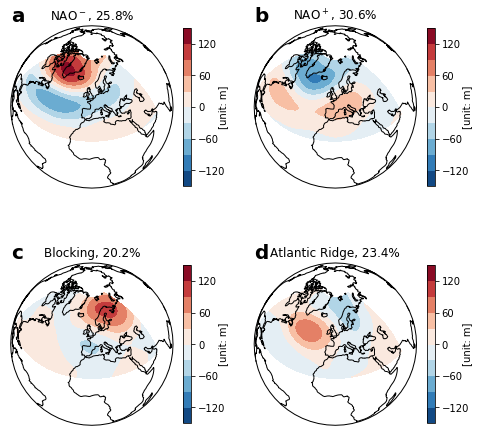

In [6]:
x,y = np.meshgrid(da.X, da.Y)
proj = ccrs.Orthographic(0,45)
fig, axes = plt.subplots(2,2, figsize=(8,8), subplot_kw=dict(projection=proj))
regimes = ['NAO$^-$', 'NAO$^+$', 'Blocking', 'Atlantic Ridge']
tags = list('abcd')
for i in range(mk.n_clusters):
    onecen = mk.cluster_centers_[i,:].reshape(ny,nx, order='F')
    cs = axes.flat[i].contourf(x, y, onecen,
                               levels=np.arange(-150, 151, 30), 
                               transform=ccrs.PlateCarree(),
                               cmap='RdBu_r')
    
    cb=fig.colorbar(cs, ax=axes.flat[i], shrink=0.8, aspect=20) 
    cb.set_label('[unit: m]',labelpad=-7)    
    axes.flat[i].coastlines()
    axes.flat[i].set_global()
  
    title = '{}, {:4.1f}%'.format(regimes[i], get_cluster_fraction(mk, i)*100)
    axes.flat[i].set_title(title)
    plt.text(0, 1, tags[i], 
             transform=axes.flat[i].transAxes, 
             va='bottom', 
             fontsize=plt.rcParams['font.size']*2, 
             fontweight='bold')   

## References

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) 

Cassou C. (2008). Intraseasonal interaction between the Madden–Julian Oscillation and the North Atlantic Oscillation Nature 455 523–7.

Yiou P. and Nogaj M.(2004). Extreme climatic events and weather regimes over the North Atlantic: when and where? Geophys. Res.
Lett. 31 L07202